# Scatter Plot

Replicating the scatter plot from the [Datalytix blog post](https://www.datalytyx.com/eurovision-song-contest-regression-analysis-highlights-the-voting-patterns/).

In the blog post it's explained that:

> The plot is calculated using a performing country’s average points and the total points given to a specific country by a voter. The juicy part is the top right quadrant, and a set was created by picking out a selection where the average points received was over 5, and the total points received was over a 100. This removes highlights in the top left quadrant that are yet to become trends, leaving only consistent voting patterns.

In [1]:
import pandas as pd
import plotly.offline as py
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pickle

py.init_notebook_mode(connected=True)

In [2]:
# Load in the data
df = pd.read_csv('../data/eurovision_merged_covariates_03Feb.csv')
df.head()

,Unnamed: 0,Year,From country,Votes,Country,Own,English,Other,has_border,migration_band,migration_year,code,code3,population,count,prop_emigrants,Gender,comps_since_last_win
0,0,1999,AT,12.0,Bosnia and Herzegovina,0.0,0.0,1.0,NaN,2000,2000,BA,BIH,4179350.0,273,0.000065,group,43
1,1,1999,AT,0.0,Belgium,0.0,1.0,0.0,NaN,2000,2000,BE,BEL,10251250.0,2486,0.000243,female,12
2,2,1999,AT,0.0,Cyprus,1.0,0.0,0.0,NaN,2000,2000,CY,CYP,948237.0,161,0.000170,female,43
3,3,1999,AT,10.0,Germany,0.0,0.0,1.0,1.0,2000,2000,DE,DEU,82211508.0,181487,0.002208,group,16
4,4,1999,AT,5.0,Denmark,0.0,1.0,0.0,NaN,2000,2000,DK,DNK,5339616.0,1525,0.000286,group,35


In [3]:
# Get the full set of country codes
countries = df['From country'].unique()
print('Number of countries: {}'.format(len(countries)))

Number of countries: 48


In [4]:
# Load the codes pickle so we can convert to proper names
with open('../data/country_codes_dict.pickle', 'rb') as f:
    codes = pickle.load(f)
# Reverse the keys and values
codes = {y: x.title() for x, y in codes.items()}
print('Number of codes: {}'.format(len(codes)))

Number of codes: 49


In [5]:
# Create a new dataframe containing the data for the scatter plot
votes = pd.DataFrame({'performer': [], 'voter': [], 'times_competed': [], 'times_voted': [], 'total_points': [], 'average_points': []})

# Compare every country with every other country
for performer in countries:
    times_competed = len(df.loc[df['code'] == performer]['Year'].unique())
    for voter in countries:
        times_voted = len(df.loc[(df['code'] == performer) & (df['From country'] == voter) & (df['Votes'] > 0)])
        total_points = df.loc[(df['code'] == performer) & (df['From country'] == voter)]['Votes'].sum()
        average_points = df.loc[(df['code'] == performer) & (df['Votes'] >= 0) & (df['From country'] == voter)]['Votes'].mean()
        votes.loc[len(votes)] = [codes[performer], codes[voter], times_competed, times_voted, total_points, average_points]
print('Check every country is matched with very other: {}'.format(len(countries)**2 == len(votes)))

Check every country is matched with very other: True


<AxesSubplot: xlabel='total_points', ylabel='average_points'>

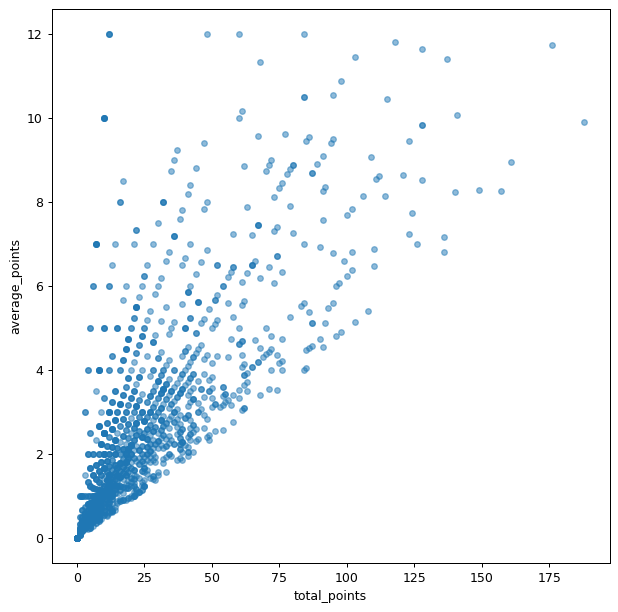

In [6]:
# Render a basic static scatter plot
fig = plt.figure(figsize=(8, 8), dpi=90)
votes.plot.scatter(x='total_points', y='average_points', alpha=0.5, ax = plt.gca())

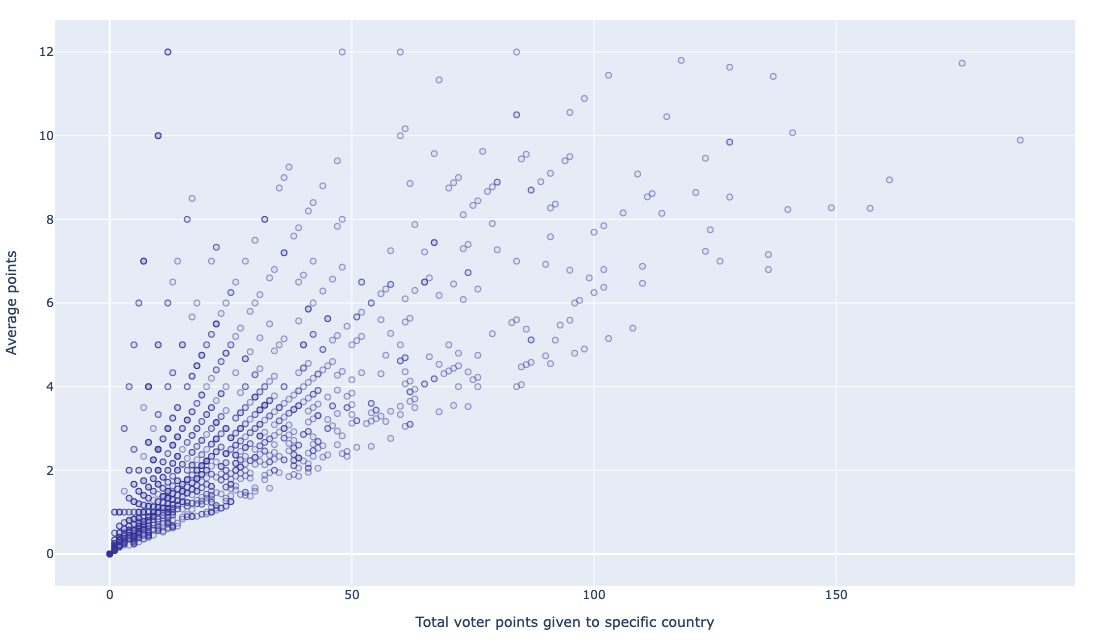

In [7]:
# Render an interactive (hoverable) plot
fig = px.scatter(votes, x='total_points', y='average_points')
fig.update_traces(hovertemplate='Performer: %{customdata[0]}'
                  + '<br>Voter: %{customdata[1]}'
                  + '<br>Total Eurovisions competed: %{customdata[2]}'
                  + '<br>Total times voted for by selected country: %{customdata[3]}'
                  + '<br>Total points given: %{customdata[4]}'
                  + '<br>Average points: %{customdata[5]:.2f}',
                  customdata=votes,
                  marker={'color': 'rgba(50, 50, 150, 0.1)', 'opacity': 0.5, 'size': 6,
                          'line': {'color': 'rgba(50, 50, 150, 1.0)', 'width': 1}})
fig.update_layout(hoverlabel_align='left', width=640, height=640, margin=dict(l=20, r=20, t=20, b=20),
                  xaxis={'title': 'Total voter points given to specific country'},
                  yaxis={'title': 'Average points'})
fig.show()